<center><font size="7"><b>Preprocessing</b></font></center>

# Import required modules

In [1]:
import pandas as pd
from astropy.io.votable import parse
import os
import seaborn as sns
import numpy as np
import scipy as sp
import coord_transform as coord
import time
from scipy.spatial import distance

# Find .vot file in directory

In [2]:
data_file = ""
for file in os.listdir(os.getcwd()):
    if file.endswith(".vot"):
        data_file = file

# Load dataset

In [3]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [4]:
df = votable_to_pandas(data_file)

In [5]:
df

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,dr2_radial_velocity,dr2_radial_velocity_error
0,4282338859504214528,282.785908,0.011250,5.648257,0.010881,0.932263,0.012898,0.032933,0.013984,-3.393563,0.014206,17.328890,0.455194
1,4089436927451879424,276.307287,0.015868,-23.559144,0.014007,0.480759,0.016674,-1.294703,0.021944,-4.438685,0.016833,-4.846311,0.431333
2,4282339611113854720,282.717639,0.018980,5.678589,0.018446,4.895652,0.023608,12.920215,0.022806,-12.157485,0.020005,-17.226954,0.598977
3,4089436961811610752,276.261810,0.019102,-23.575342,0.016849,0.889500,0.018416,2.852077,0.026938,2.816054,0.020369,-9.293663,14.794000
4,4282339718497802368,282.693206,0.044804,5.676382,0.047415,0.220562,0.056072,-2.776552,0.052576,-5.106474,0.047889,101.800797,3.921371
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180461,6056109912690990208,196.443925,0.008734,-59.708078,0.010616,0.345771,0.014380,-5.967731,0.011590,0.257960,0.014352,-36.252293,1.029703
7180462,6056110153209542784,196.704875,0.008982,-60.019421,0.010622,0.921323,0.014480,-8.120991,0.012039,-0.255920,0.014669,7.458117,5.133635
7180463,6056110256288763136,196.736272,0.010899,-60.009747,0.012719,0.347871,0.017093,-7.450814,0.014529,-1.491618,0.017644,-45.831112,2.259007
7180464,6056110599886154880,196.789455,0.008566,-59.994962,0.010127,0.172409,0.013939,-8.214466,0.011524,0.098175,0.013726,-7.874334,1.049933


# Reduce data

In [6]:
df_reduced = df[4.5 > df["parallax"]/df["parallax_error"]]

In [7]:
df_reduced.shape

(176404, 13)

# Calculate distance in pc

In [88]:
df_conv = pd.DataFrame()

In [89]:
start = time.perf_counter()
df_conv["distance_pc"] = 1./df_reduced["parallax"]
end = time.perf_counter()
end-start

0.012951838999924803

In [90]:
df_conv.shape

(176404, 1)

In [91]:
df_conv = df_conv[df_conv["distance_pc"]>0]

In [92]:
df_conv

,distance_pc
4,4.533882
7,8.251274
30,2.974852
59,13.093292
63,51.907321
...,...
7180261,8.836949
7180340,24.408366
7180389,8.679258
7180413,13.884487


In [93]:
df_conv.shape

(160109, 1)

# Converting from spherical to cartesian coordinates

In [94]:
df_conv["x"], df_conv["y"], df_conv["z"] = coord.sph2cart(df_conv["distance_pc"], df_reduced["ra"], df_reduced["dec"])

In [95]:
df_conv["vx"],df_conv["vy"],df_conv["vz"] = coord.vsph2cart(df_reduced["dr2_radial_velocity"], df_reduced["pmra"], df_reduced["pmdec"], df_conv["distance_pc"], df_reduced["ra"], df_reduced["dec"])

In [96]:
pv_6d = np.array([df_conv["x"], df_conv["y"], df_conv["z"], df_conv["vx"], df_conv["vy"], df_conv["vz"]])

# Create 2 sets of sources

In [386]:
# Set target star
STAR_NUM=100
NDENSE=20

In [369]:
df_conv

,distance_pc,x,y,z,vx,vy,vz
4,4.533882,3.719793,-0.186641,-2.585420,69.817764,-13.857310,-77.070223
7,8.251274,6.737695,3.800255,-2.871419,164.664822,53.223960,-84.625624
30,2.974852,2.527311,0.167956,-1.560204,5.279663,-4.895415,-28.628855
59,13.093292,11.436229,1.327061,-6.235854,45.514481,-33.959848,-114.773071
63,51.907321,20.418319,9.380248,-46.791807,-114.175047,-145.084067,-52.722591
...,...,...,...,...,...,...,...
7180261,8.836949,-4.774041,-6.837971,2.922729,-50.766165,15.044939,14.025305
7180340,24.408366,9.447117,-2.685535,22.345206,-8.255152,-48.545954,19.383718
7180389,8.679258,-0.853836,-8.295204,2.406256,-55.384073,27.418705,-8.252534
7180413,13.884487,-1.792584,-13.430945,3.029083,-72.398399,18.842831,4.259836


### Create one set with stars within 2pc from our target and second set with stars within 15pc

In [370]:
target = df_conv.iloc[[STAR_NUM], [1,2,3]].to_numpy()[0]
arr_40pc = []
arr_60pc = []

for i, row in df_conv.iterrows():
    dist = np.linalg.norm(target-[row[1], row[2], row[3]])

    if dist < 2:
        arr_40pc.append([row[1], row[2], row[3], row[4], row[5], row[6]])
    if dist < 15:
        arr_60pc.append([row[1], row[2], row[3], row[4], row[5], row[6]])


In [387]:
len(arr_40pc), len(arr_60pc)

(289, 50553)

# Calculating the Mahalanobis distance

In [373]:
arr_40pc_6d = np.array(arr_40pc)

In [374]:
arr_60pc_6d = np.array(arr_60pc)
arr_60pc_cov_mat = np.cov(arr_60pc_6d.T) # Calculate the covariance matrix
arr_60pc_inv = np.linalg.inv(arr_60pc_cov_mat) # Determine the inverse matrix

### For each star within 2pc from our target calculate mahalanobis distance for all stars within 15pc

In [375]:
start = time.perf_counter()
mah_dist_arr = []
for i in range(arr_40pc_6d.shape[0]):
    mahal_dist = np.zeros(arr_60pc_6d.shape[0])
    for j in range(arr_60pc_6d.shape[0]):
        mahal_dist[j] = distance.mahalanobis(arr_60pc_6d[i], arr_60pc_6d[j], arr_60pc_inv)
    mah_dist_arr.append(mahal_dist)
end = time.perf_counter()
end - start

122.57900627699928

### Sort and get 20th closest neighbour

In [376]:
start = time.perf_counter()
mahal_dist_ndense = np.zeros(len(mah_dist_arr))
for i in range(len(mah_dist_arr)):
    mahal_dist_ndense[i] = (np.sort(mah_dist_arr[i])[NDENSE])
end = time.perf_counter()
end - start

0.8228775399984443

### Convert mahalanobis distance to density

In [389]:
density = mahal_dist_ndense/np.median(mahal_dist_ndense)

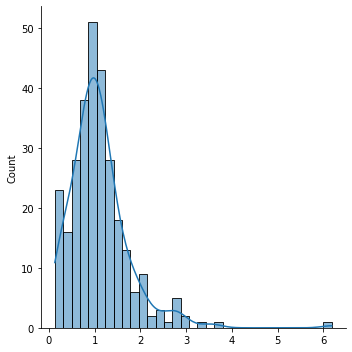

In [390]:
sns.displot(density, kde=True)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

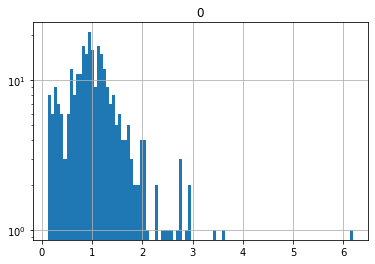

In [391]:
den = pd.DataFrame(density)
den.hist(log=True,bins=100)

# Please ignore below code

# Calculating the Mahalanobis distance

In [19]:
pv_6d = np.array([df_conv["x"], df_conv["y"], df_conv["z"], df_conv["vx"], df_conv["vy"], df_conv["vz"]])

In [20]:
pv_6d_cov_mat = np.cov(pv_6d)            # Calculate the covariance matrix

In [21]:
pv_6d_inv = np.linalg.inv(pv_6d_cov_mat) # Determine the inverse matrix

In [255]:
start = time.perf_counter()
mah_dist_arr = []
for j in range(100):
    mahal_dist = np.zeros(pv_6d.shape[1])
    for i in range(len(mahal_dist)):
        mahal_dist[i] = distance.mahalanobis(pv_6d.T[j], pv_6d.T[i], pv_6d_inv)
    mah_dist_arr.append(mahal_dist)
end = time.perf_counter()
end - start

KeyboardInterrupt: 

In [30]:
start = time.perf_counter()
mahal_dist_ndense = []
for i in range(len(mah_dist_arr)):
    mahal_dist_ndense.append(np.sort(mah_dist_arr[i])[NDENSE])
end = time.perf_counter()
end - start

0.08691025999996782

In [31]:
len(mahal_dist_ndense)

100

In [32]:
print(len(mahal_dist_ndense))
new =[]
for i in range(len(mahal_dist_ndense)):
    if mahal_dist_ndense[i] > 0.2:
        continue
    new.append(mahal_dist_ndense[i])
print(len(mahal_dist_ndense))

100
100


In [ ]:
#divide density by median of the whole set

In [34]:
sns.displot(mahal_dist_ndense, kde=True)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc07fef0d30> (for post_execute):


KeyboardInterrupt: 